In [1]:
import sys

sys.path.append('..')

import optuna
from sklearn import datasets
from sklearn.svm import SVC

# DEID libraries
import gojo
from gojo import core

In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

In [3]:
# evaluate the model using a simple cross-validation strategy with a 
# default parameters
cv_report = core.evalCrossVal(
    X=X,
    y=y,
    model=core.SklearnModelWrapper(
        SVC, kernel='poly', degree=1, coef0=0.0,
        cache_size=1000, class_weight='balanced'
    ),
    cv=gojo.util.getCrossValObj(cv=5, stratified=True, loocv=False, random_state=1997),
    verbose=True,
    save_train_preds=True,
    save_models=False,
    n_jobs=1
)
scores = cv_report.getScores(core.getDefaultMetrics('binary_classification', bin_threshold=0.5))
scores['test']

Making predictions...: 5it [00:01,  3.67it/s]


,accuracy,balanced_accuracy,precision,recall,sensitivity,specificity,negative_predictive_value,f1_score,auc,n_fold
0,0.666667,0.701299,0.545455,0.857143,0.857143,0.545455,0.857143,0.666667,0.701299,0
1,0.777778,0.818182,0.636364,1.000000,1.000000,0.636364,1.000000,0.777778,0.818182,1
2,0.777778,0.790476,0.684211,0.866667,0.866667,0.714286,0.882353,0.764706,0.790476,2
3,0.714286,0.738095,0.600000,0.857143,0.857143,0.619048,0.866667,0.705882,0.738095,3
4,0.800000,0.821429,0.684211,0.928571,0.928571,0.714286,0.937500,0.787879,0.821429,4


In [4]:
search_space = {
    'degree': ('suggest_int', (1, 10)),
    'coef0': ('suggest_float', (0.0, 100.00 ))
}
model = core.SklearnModelWrapper(
    SVC, kernel='poly', degree=1, coef0=0.0,
    cache_size=1000, class_weight='balanced'
)

In [7]:
# perform the HPO to optimice model-hyperparameters
cv_report = core.evalCrossValNestedHPO(
    X=X,
    y=y,
    model=model,
    search_space=search_space,
    outer_cv=gojo.util.getCrossValObj(cv=5, stratified=True, loocv=False, random_state=1997),
    inner_cv=gojo.util.getCrossValObj(cv=5, stratified=True, loocv=False, random_state=1997),
    hpo_sampler=optuna.samplers.TPESampler(n_startup_trials=100),
    hpo_n_trials=200,
    minimization=False,
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5),
    objective_metric='f1_score',
    verbose=1,
    save_train_preds=True,
    save_models=True,
    n_jobs=15
)


Fold 1 =============================================

Best trial: 58
Best value: -0.97308

Optimized model hyperparameters: {'degree': 10, 'coef0': 78.41207479301036}


Fold 2 =============================================

Best trial: 145
Best value: -0.97308

Optimized model hyperparameters: {'degree': 4, 'coef0': 96.14068267183902}


Fold 3 =============================================

Best trial: 126
Best value: -0.95714

Optimized model hyperparameters: {'degree': 3, 'coef0': 66.04921006737733}


Fold 4 =============================================

Best trial: 157
Best value: -0.98248

Optimized model hyperparameters: {'degree': 5, 'coef0': 96.11385655742549}


Fold 5 =============================================

Best trial: 123
Best value: -0.98333

Optimized model hyperparameters: {'degree': 9, 'coef0': 95.6165281082545}



In [13]:
scores = cv_report.getScores(core.getDefaultMetrics('binary_classification', bin_threshold=0.5))
scores['test']

,accuracy,balanced_accuracy,precision,recall,sensitivity,specificity,negative_predictive_value,f1_score,auc,n_fold
0,0.944444,0.941558,0.928571,0.928571,0.928571,0.954545,0.954545,0.928571,0.941558,0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,0.944444,0.933333,1.000000,0.866667,0.866667,1.000000,0.913043,0.928571,0.933333,2
3,0.942857,0.940476,0.928571,0.928571,0.928571,0.952381,0.952381,0.928571,0.940476,3
4,0.885714,0.880952,0.857143,0.857143,0.857143,0.904762,0.904762,0.857143,0.880952,4


<Axes: >

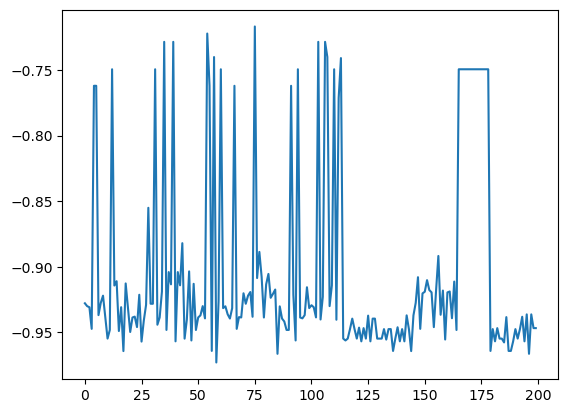

In [15]:
cv_report.metadata['hpo_history'][0]['value'].plot()

In [5]:
# test a custom aggregation function as optimization objective
def adocMetric(_scores):
    f1_test = _scores['test']['f1_score'].mean()
    f1_train = _scores['train']['f1_score'].mean()
    pen1 = 2 * abs(f1_test - f1_train)
    pen2 = 2 * _scores['test']['f1_score'].std()
    
    return f1_test - (pen1 + pen2)

cv_report2 = core.evalCrossValNestedHPO(
    X=X,
    y=y,
    model=model,
    search_space=search_space,
    outer_cv=gojo.util.getCrossValObj(cv=5, stratified=True, loocv=False, random_state=1997),
    inner_cv=gojo.util.getCrossValObj(cv=5, stratified=True, loocv=False, random_state=1997),
    hpo_sampler=optuna.samplers.TPESampler(n_startup_trials=100),
    hpo_n_trials=200,
    minimization=False,
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5),
    objective_metric='f1_score',
    agg_function=adocMetric,
    verbose=-1,
    save_train_preds=True,
    save_models=True,
    n_jobs=15
)

[I 2023-10-03 18:39:34,793] A new study created in memory with name: no-name-7435211f-32a0-4a73-a76e-99a8cdb114d7



Fold 1 =============================================



[I 2023-10-03 18:39:36,022] Trial 5 finished with value: -0.5090577236867833 and parameters: {'degree': 2, 'coef0': 7.715941809546689}. Best is trial 5 with value: -0.5090577236867833.
[I 2023-10-03 18:39:36,128] Trial 14 finished with value: -0.5044710734843244 and parameters: {'degree': 2, 'coef0': 47.497901987758226}. Best is trial 5 with value: -0.5090577236867833.
[I 2023-10-03 18:39:36,137] Trial 9 finished with value: -0.6783274584465566 and parameters: {'degree': 10, 'coef0': 32.85690051935761}. Best is trial 9 with value: -0.6783274584465566.
[I 2023-10-03 18:39:36,142] Trial 2 finished with value: -0.5476053768214744 and parameters: {'degree': 3, 'coef0': 18.80404559401192}. Best is trial 9 with value: -0.6783274584465566.
[I 2023-10-03 18:39:36,154] Trial 12 finished with value: -0.6441499272290687 and parameters: {'degree': 6, 'coef0': 40.705628514892155}. Best is trial 9 with value: -0.6783274584465566.
[I 2023-10-03 18:39:36,172] Trial 3 finished with value: -0.7726897724

Best trial: 157
Best value: -0.89719

Optimized model hyperparameters: {'degree': 3, 'coef0': 93.33060673823785}


Fold 2 =============================================



[I 2023-10-03 18:39:55,209] Trial 1 finished with value: -0.8506834997664402 and parameters: {'degree': 3, 'coef0': 94.91629234363783}. Best is trial 1 with value: -0.8506834997664402.
[I 2023-10-03 18:39:55,789] Trial 7 finished with value: -0.7522612666069739 and parameters: {'degree': 7, 'coef0': 3.2121331200744896}. Best is trial 1 with value: -0.8506834997664402.
[I 2023-10-03 18:39:56,088] Trial 3 finished with value: -0.7610428496112013 and parameters: {'degree': 4, 'coef0': 36.95785448482255}. Best is trial 1 with value: -0.8506834997664402.
[I 2023-10-03 18:39:56,441] Trial 11 finished with value: -0.6399349047468361 and parameters: {'degree': 6, 'coef0': 29.02208018321949}. Best is trial 1 with value: -0.8506834997664402.
[I 2023-10-03 18:39:56,447] Trial 10 finished with value: -0.7225293353515589 and parameters: {'degree': 9, 'coef0': 86.10364477478343}. Best is trial 1 with value: -0.8506834997664402.
[I 2023-10-03 18:39:56,466] Trial 0 finished with value: -0.674743594065

Best trial: 127
Best value: -0.87227

Optimized model hyperparameters: {'degree': 3, 'coef0': 86.65061772497151}


Fold 3 =============================================



[I 2023-10-03 18:40:16,603] Trial 3 finished with value: -0.6882045914096611 and parameters: {'degree': 3, 'coef0': 28.03574290345817}. Best is trial 3 with value: -0.6882045914096611.
[I 2023-10-03 18:40:16,676] Trial 8 finished with value: -0.623477477593928 and parameters: {'degree': 6, 'coef0': 40.41900105957863}. Best is trial 3 with value: -0.6882045914096611.
[I 2023-10-03 18:40:16,683] Trial 2 finished with value: -0.5551667814329901 and parameters: {'degree': 2, 'coef0': 69.1713407174128}. Best is trial 3 with value: -0.6882045914096611.
[I 2023-10-03 18:40:16,699] Trial 10 finished with value: -0.6326642500737195 and parameters: {'degree': 2, 'coef0': 40.31193112498308}. Best is trial 3 with value: -0.6882045914096611.
[I 2023-10-03 18:40:16,708] Trial 13 finished with value: -0.6825154262438541 and parameters: {'degree': 6, 'coef0': 35.10024201890764}. Best is trial 3 with value: -0.6882045914096611.
[I 2023-10-03 18:40:16,719] Trial 5 finished with value: -0.623477477593928

Best trial: 118
Best value: -0.83690

Optimized model hyperparameters: {'degree': 4, 'coef0': 15.1444492687071}


Fold 4 =============================================



[I 2023-10-03 18:40:36,502] Trial 4 finished with value: -0.43378660845332484 and parameters: {'degree': 1, 'coef0': 18.396301622352585}. Best is trial 4 with value: -0.43378660845332484.
[I 2023-10-03 18:40:36,507] Trial 7 finished with value: -0.7046266849827674 and parameters: {'degree': 7, 'coef0': 25.967070457768738}. Best is trial 7 with value: -0.7046266849827674.
[I 2023-10-03 18:40:36,518] Trial 5 finished with value: -0.7680926159801491 and parameters: {'degree': 5, 'coef0': 33.57759278456195}. Best is trial 5 with value: -0.7680926159801491.
[I 2023-10-03 18:40:36,520] Trial 2 finished with value: -0.7226778195014782 and parameters: {'degree': 5, 'coef0': 10.282753865456872}. Best is trial 5 with value: -0.7680926159801491.
[I 2023-10-03 18:40:36,561] Trial 8 finished with value: -0.5723464595769363 and parameters: {'degree': 5, 'coef0': 0.2916367752318405}. Best is trial 5 with value: -0.7680926159801491.
[I 2023-10-03 18:40:36,592] Trial 6 finished with value: -0.258625951

Best trial: 164
Best value: -0.92196

Optimized model hyperparameters: {'degree': 3, 'coef0': 96.51788711518786}


Fold 5 =============================================



[I 2023-10-03 18:40:56,106] Trial 6 finished with value: -0.8453870503682315 and parameters: {'degree': 9, 'coef0': 72.75760011612192}. Best is trial 6 with value: -0.8453870503682315.
[I 2023-10-03 18:40:56,108] Trial 10 finished with value: -0.7580001647919552 and parameters: {'degree': 7, 'coef0': 76.63080867471182}. Best is trial 6 with value: -0.8453870503682315.
[I 2023-10-03 18:40:56,110] Trial 7 finished with value: -0.5767121964283599 and parameters: {'degree': 1, 'coef0': 79.23622500250704}. Best is trial 6 with value: -0.8453870503682315.
[I 2023-10-03 18:40:56,130] Trial 0 finished with value: -0.8654464550670274 and parameters: {'degree': 7, 'coef0': 4.120732015306028}. Best is trial 0 with value: -0.8654464550670274.
[I 2023-10-03 18:40:56,145] Trial 11 finished with value: -0.7795219217722489 and parameters: {'degree': 4, 'coef0': 64.09992583484176}. Best is trial 0 with value: -0.8654464550670274.
[I 2023-10-03 18:40:56,156] Trial 8 finished with value: -0.5492602788647

Best trial: 148
Best value: -0.92884

Optimized model hyperparameters: {'degree': 5, 'coef0': 65.72474422944661}



In [12]:
scores2 = cv_report2.getScores(core.getDefaultMetrics('binary_classification', bin_threshold=0.5))
scores2['test']

,accuracy,balanced_accuracy,precision,recall,sensitivity,specificity,negative_predictive_value,f1_score,auc,n_fold
0,0.972222,0.964286,1.000000,0.928571,0.928571,1.000000,0.956522,0.962963,0.964286,0
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
2,0.916667,0.909524,0.928571,0.866667,0.866667,0.952381,0.909091,0.896552,0.909524,2
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3
4,0.942857,0.940476,0.928571,0.928571,0.928571,0.952381,0.952381,0.928571,0.940476,4


<Axes: >

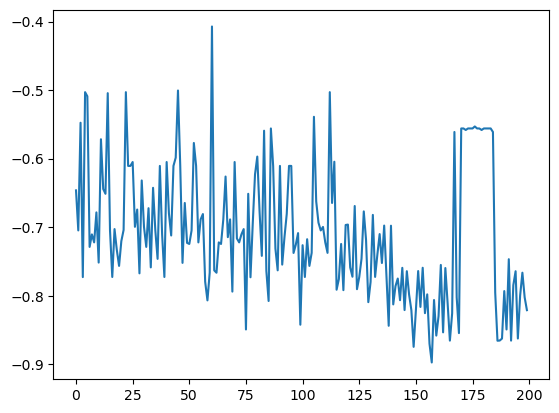

In [16]:
cv_report2.metadata['hpo_history'][0]['value'].plot()

In [19]:
cv_report2.metadata['hpo_best_params']

{0: {'degree': 3, 'coef0': 93.33060673823785},
 1: {'degree': 3, 'coef0': 86.65061772497151},
 2: {'degree': 4, 'coef0': 15.1444492687071},
 3: {'degree': 3, 'coef0': 96.51788711518786},
 4: {'degree': 5, 'coef0': 65.72474422944661}}

In [21]:
cv_report.metadata['hpo_best_params']

{0: {'degree': 10, 'coef0': 78.41207479301036},
 1: {'degree': 4, 'coef0': 96.14068267183902},
 2: {'degree': 3, 'coef0': 66.04921006737733},
 3: {'degree': 5, 'coef0': 96.11385655742549},
 4: {'degree': 9, 'coef0': 95.6165281082545}}